
1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')


Calculating Volatility Matrix...
Data Ready.
Starting Simulation (2000-01-01)...


C:\Users\65964\AppData\Local\Temp\ipykernel_44584\1250160871.py:300: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start=START_DATE, progress=False)['Close']



SIMULATION RESULTS
Final Balance: $4,256,036.37
CAGR:          18.74%
Max Drawdown:  -29.17%
Total Trades:  10978
------------------------------------------------------------

LATEST 10 TRADES:
      Date Ticker     Action  Strike  Qty  Price  Total_Flow  Realized_PnL         Notes
2025-11-10   TSLA BTC_PROFIT  401.59    8   9.40     7522.35       8961.65 Profit: 54.4%
2025-11-10   TSLA   SELL_PUT  407.00    8  21.13    16904.42          0.00    IV: 53.22%
2025-11-14   COIN BTC_PROFIT  364.01    8   1.55     1243.66       7610.89 Profit: 86.0%
2025-11-14     GM BTC_PROFIT   62.21   53   1.04     5520.05      10281.21 Profit: 65.2%
2025-11-14   COIN  SELL_CALL  331.33    8  11.41     9128.05          0.00  Covered Call
2025-11-14     GM   SELL_PUT   65.18   52   3.30    17138.31          0.00    IV: 50.11%
2025-11-17   LULU BTC_PROFIT  178.40   11   0.86      949.19       2592.45 Profit: 73.3%
2025-11-17   LULU  SELL_CALL  178.25   11   3.92     4316.31          0.00  Covered Call
2025

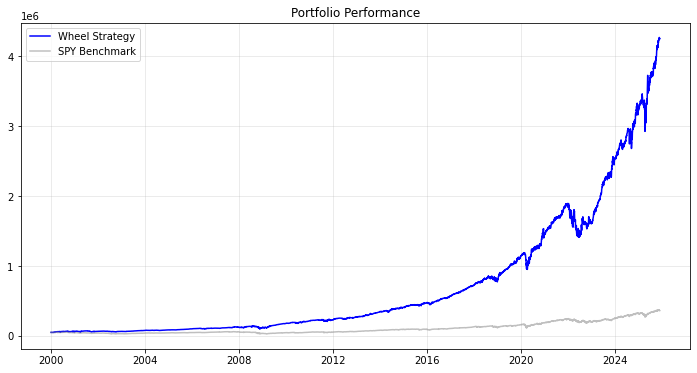

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import timedelta

# ==========================================
# 1. CONFIGURATION
# ==========================================
START_DATE = "2000-01-01" 
INITIAL_CAPITAL = 50000    
LEVERAGE_CAP = 1.25         # Max 1.25x leverage
MAX_POSITIONS = 12          # Max concurrent positions
ALLOCATION_PER_TRADE = 0.08 # Target 8% of Net Liq per trade
TARGET_DELTA = 0.30
TRADING_FEE = 0.65          # $0.65 per contract

# STRATEGY RULES
MIN_DTE = 30
MAX_DTE = 45
PROFIT_TAKE_PCT = 0.50      # Close at 50% Profit
FAST_PROFIT_DAYS = 10       # Or close if >50% profit in <10 days

# THE UNIVERSE (High Volatility / Liquid / Quality Mix)
TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA',
    'AMD', 'INTC', 'QCOM', 'AVGO', 'TXN', 'MU', 'LRCX', 'AMAT',
    'CRM', 'ADBE', 'NOW', 'SNOW', 'UBER', 'SQ', 'SHOP', 'COIN',
    'JPM', 'GS', 'MS', 'V', 'MA', 'PYPL', 'BLK',
    'HD', 'MCD', 'SBUX', 'NKE', 'LULU', 'CMG', 'COST', 'WMT',
    'CAT', 'BA', 'GE', 'XOM', 'CVX', 'EOG', 'SLB',
    'LLY', 'UNH', 'MRK', 'AMGN', 'VRTX', 'DIS', 'F', 'GM'
]

# ==========================================
# 2. MATH & LOGIC
# ==========================================
def black_scholes(S, K, T, r, sigma, option_type='put'):
    if sigma <= 0.001: sigma = 0.001
    if T <= 0.001: T = 0.001
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
    else: 
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    return price, delta

def find_strike(S, T, r, sigma, target_delta, option_type='put'):
    strikes = np.linspace(S * 0.5, S * 1.5, 100)
    best_k = strikes[0]
    min_diff = 1.0
    for K in strikes:
        _, delta = black_scholes(S, K, T, r, sigma, option_type)
        diff = abs(abs(delta) - target_delta)
        if diff < min_diff:
            min_diff = diff
            best_k = K
    return round(best_k, 2)

# ==========================================
# 3. DATA INGESTION
# ==========================================
print(f"Downloading data for {len(TICKERS)} tickers...")
raw = yf.download(TICKERS + ['^VIX', '^TNX'], start=START_DATE, progress=False, auto_adjust=False)

# Robust Column Handling
if isinstance(raw.columns, pd.MultiIndex):
    try:
        if 'Close' in raw.columns.get_level_values(0):
            df_close = raw['Close'].copy()
        else:
            df_close = raw.swaplevel(0, 1, axis=1)['Close'].copy()
    except:
        df_close = raw['Adj Close'].copy()
else:
    df_close = raw

# Market Data separation
vix = df_close['^VIX'].fillna(20.0)
tnx = (df_close['^TNX'].fillna(4.0)) / 100
stocks = df_close.drop(columns=['^VIX', '^TNX'], errors='ignore')

# Calculate Volatility Rankings
print("Calculating Volatility Matrix...")
returns = stocks.pct_change()
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)

print("Data Ready.")

# ==========================================
# 4. SIMULATION ENGINE (WITH LOGGING)
# ==========================================
cash = INITIAL_CAPITAL
portfolio = []  
holdings = {t: 0 for t in TICKERS}
equity_curve = []
full_trade_log = [] # <--- THE MASTER LOG

def log_trade(date, ticker, action, strike, quantity, price, pnl=0, notes=""):
    full_trade_log.append({
        'Date': date.strftime('%Y-%m-%d'),
        'Ticker': ticker,
        'Action': action,
        'Strike': strike,
        'Qty': quantity,
        'Price': round(price, 2), # Premium per share
        'Total_Flow': round(price * 100 * quantity if 'BUY' not in action else -price * 100 * quantity, 2),
        'Realized_PnL': round(pnl, 2),
        'Notes': notes
    })

print(f"Starting Simulation ({START_DATE})...")

for date in stocks.index:
    # Skip warmup
    if date not in rolling_vol.index or pd.isna(tnx.loc[date]): continue
    
    current_r = tnx.loc[date]
    current_vix = vix.loc[date]
    
    # --- A. MANAGE EXISTING POSITIONS ---
    active_port = []
    
    # Get active prices
    active_symbols = list(set([p['symbol'] for p in portfolio]))
    curr_prices = stocks.loc[date, active_symbols] if active_symbols else {}
    
    for pos in portfolio:
        sym = pos['symbol']
        if sym not in curr_prices or pd.isna(curr_prices[sym]):
            active_port.append(pos) # Halt/No Data, keep open
            continue
            
        S = curr_prices[sym]
        T_days = (pos['expiry'] - date).days
        T_year = max(T_days / 365.0, 0.0001)
        
        # Pricing
        stock_vol = rolling_vol.loc[date, sym]
        if pd.isna(stock_vol): stock_vol = current_vix / 100
        sigma = (stock_vol * 1.2) if pos['type'] == 'put' else stock_vol
        
        curr_opt_price, _ = black_scholes(S, pos['strike'], T_year, current_r, sigma, pos['type'])
        
        # PnL Calculation
        # If Short Put: Entry 1.00, Curr 0.50 -> Profit 0.50
        gross_pnl_pct = (pos['entry_price'] - curr_opt_price) / pos['entry_price']
        days_held = (date - pos['entry_date']).days
        
        closed = False
        
        # 1. CHECK EXPIRATION
        if T_days <= 0:
            closed = True
            if pos['type'] == 'put':
                if S < pos['strike']:
                    # ASSIGNMENT
                    cost = pos['strike'] * 100 * pos['qty']
                    cash -= cost
                    holdings[sym] += 100 * pos['qty']
                    
                    # Log the Option Close (Full Profit on Premium kept) AND the Stock Buy
                    pnl_val = (pos['entry_price'] * 100 * pos['qty']) - (pos['qty'] * TRADING_FEE)
                    log_trade(date, sym, 'EXPIRED_ASSIGNED', pos['strike'], pos['qty'], 0, pnl_val, "Assigned Shares")
                    log_trade(date, sym, 'STOCK_BUY_ASSIGN', 0, 100 * pos['qty'], S, 0, f"Bought at Strike {pos['strike']}")
                else:
                    # WORTHLESS
                    pnl_val = (pos['entry_price'] * 100 * pos['qty']) - (pos['qty'] * TRADING_FEE)
                    log_trade(date, sym, 'EXPIRED_WIN', pos['strike'], pos['qty'], 0, pnl_val, "Full Premium Keep")
                    
            elif pos['type'] == 'call':
                if S > pos['strike']:
                    # CALLED AWAY
                    rev = pos['strike'] * 100 * pos['qty']
                    cash += rev
                    holdings[sym] -= 100 * pos['qty']
                    
                    pnl_val = (pos['entry_price'] * 100 * pos['qty']) - (pos['qty'] * TRADING_FEE)
                    log_trade(date, sym, 'CALLED_AWAY', pos['strike'], pos['qty'], 0, pnl_val, "Shares Sold")
                    log_trade(date, sym, 'STOCK_SELL_CALL', 0, 100 * pos['qty'], S, 0, f"Sold at Strike {pos['strike']}")
                else:
                    # WORTHLESS
                    pnl_val = (pos['entry_price'] * 100 * pos['qty']) - (pos['qty'] * TRADING_FEE)
                    log_trade(date, sym, 'EXPIRED_WIN', pos['strike'], pos['qty'], 0, pnl_val, "Keep Shares & Prem")

        # 2. CHECK PROFIT TAKE
        elif not closed:
            cond1 = (days_held <= FAST_PROFIT_DAYS) and (gross_pnl_pct >= PROFIT_TAKE_PCT)
            cond2 = (days_held >= (pos['orig_dte']/2)) and (gross_pnl_pct >= PROFIT_TAKE_PCT)
            
            if cond1 or cond2:
                # BUY TO CLOSE
                debit = curr_opt_price * 100 * pos['qty']
                fee = TRADING_FEE * pos['qty']
                cash -= (debit + fee)
                
                # Calc Realized PnL
                entry_amt = (pos['entry_price'] * 100 * pos['qty'])
                exit_amt = debit + fee
                pnl_realized = entry_amt - exit_amt - (pos['qty'] * TRADING_FEE) # Initial fee too
                
                log_trade(date, sym, 'BTC_PROFIT', pos['strike'], pos['qty'], curr_opt_price, pnl_realized, f"Profit: {gross_pnl_pct:.1%}")
                closed = True
        
        if not closed:
            active_port.append(pos)
    
    portfolio = active_port

    # --- B. SCANNER (OPEN NEW TRADES) ---
    stock_val = sum([holdings[t] * stocks.loc[date, t] for t in holdings if holdings[t] != 0 and not pd.isna(stocks.loc[date,t])])
    net_liq = cash + stock_val
    buying_power = net_liq * LEVERAGE_CAP
    
    # Calc Used Margin
    used_margin = sum([(p['strike'] * 100 * p['qty']) * 0.20 for p in portfolio if p['type']=='put'])
    
    # 1. Covered Calls (Priority)
    for t in TICKERS:
        if holdings[t] >= 100:
            # Check if we already have a call sold against it
            has_call = any(p['symbol'] == t and p['type'] == 'call' for p in portfolio)
            if not has_call:
                vol = rolling_vol.loc[date, t]
                if pd.isna(vol): continue
                
                S = stocks.loc[date, t]
                target_k = find_strike(S, MAX_DTE/365, current_r, vol, 0.30, 'call')
                prem, _ = black_scholes(S, target_k, MAX_DTE/365, current_r, vol, 'call')
                
                num_contracts = int(holdings[t] // 100)
                
                if prem > (S * 0.005):
                    total_prem = (prem * 100 * num_contracts) - (num_contracts * TRADING_FEE)
                    cash += total_prem
                    expiry = date + timedelta(days=MAX_DTE)
                    
                    portfolio.append({
                        'symbol': t, 'type': 'call', 'strike': target_k, 'expiry': expiry,
                        'entry_date': date, 'entry_price': prem, 'orig_dte': MAX_DTE, 'qty': num_contracts
                    })
                    log_trade(date, t, 'SELL_CALL', target_k, num_contracts, prem, 0, "Covered Call")

    # 2. Cash Secured Puts (Volatility Scan)
    if len(portfolio) < MAX_POSITIONS and used_margin < (buying_power * 0.80):
        # Filter & Sort by Volatility
        valid = rolling_vol.loc[date].dropna().sort_values(ascending=False)
        candidates = [x for x in valid.index if x in TICKERS and stocks.loc[date, x] > 15]
        
        for t in candidates[:20]: # Look at top 20 volatile stocks
            if len(portfolio) >= MAX_POSITIONS: break
            if any(p['symbol'] == t for p in portfolio): continue # No duplicates
            
            S = stocks.loc[date, t]
            vol = rolling_vol.loc[date, t]
            
            # Sizing
            target_k = find_strike(S, MAX_DTE/365, current_r, vol*1.2, 0.30, 'put')
            notional = target_k * 100
            
            # Calc Max Contracts allowed by Allocation Rule
            allocation_amt = net_liq * ALLOCATION_PER_TRADE
            num_contracts = int(allocation_amt // notional)
            
            if num_contracts < 1: num_contracts = 1 # Minimum 1 if we can afford margin
            
            margin_req = (notional * 0.20) * num_contracts
            
            # Check Limits
            if (used_margin + margin_req) < buying_power and (num_contracts * notional) < (net_liq * 0.20):
                prem, _ = black_scholes(S, target_k, MAX_DTE/365, current_r, vol*1.2, 'put')
                
                if prem > (S * 0.005): # Min Premium Filter
                    total_prem = (prem * 100 * num_contracts) - (num_contracts * TRADING_FEE)
                    cash += total_prem
                    expiry = date + timedelta(days=MAX_DTE)
                    
                    portfolio.append({
                        'symbol': t, 'type': 'put', 'strike': target_k, 'expiry': expiry,
                        'entry_date': date, 'entry_price': prem, 'orig_dte': MAX_DTE, 'qty': num_contracts
                    })
                    used_margin += margin_req
                    log_trade(date, t, 'SELL_PUT', target_k, num_contracts, prem, 0, f"IV: {vol:.2%}")

    equity_curve.append({'Date': date, 'Net_Liq': net_liq, 'Cash': cash})

# ==========================================
# 5. REPORTING & LOGS
# ==========================================
res = pd.DataFrame(equity_curve).set_index('Date')
trade_log_df = pd.DataFrame(full_trade_log)

# Benchmark
spy = yf.download('SPY', start=START_DATE, progress=False)['Close']
if isinstance(spy, pd.DataFrame): spy = spy.iloc[:, 0]
spy = spy.reindex(res.index).ffill()
spy_shares = INITIAL_CAPITAL / spy.iloc[0]
res['SPY'] = spy * spy_shares

# Performance Stats
cagr = (res['Net_Liq'].iloc[-1] / INITIAL_CAPITAL) ** (365.25/(res.index[-1]-res.index[0]).days) - 1
dd = (res['Net_Liq'] - res['Net_Liq'].cummax()) / res['Net_Liq'].cummax()

print("\n" + "="*60)
print("SIMULATION RESULTS")
print("="*60)
print(f"Final Balance: ${res['Net_Liq'].iloc[-1]:,.2f}")
print(f"CAGR:          {cagr:.2%}")
print(f"Max Drawdown:  {dd.min():.2%}")
print(f"Total Trades:  {len(trade_log_df)}")
print("-" * 60)

# DISPLAY TRADE LOG
print("\nLATEST 10 TRADES:")
print(trade_log_df.tail(10).to_string(index=False))

print("\n" + "="*60)
print("SAVING LOG...")
# Export to CSV
filename = "wheel_strategy_full_log.csv"
trade_log_df.to_csv(filename, index=False)
print(f"Full trade log saved to: {filename}")

# VISUALIZATION
plt.figure(figsize=(12, 6))
plt.plot(res.index, res['Net_Liq'], label='Wheel Strategy', color='blue')
plt.plot(res.index, res['SPY'], label='SPY Benchmark', color='gray', alpha=0.5)
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()